In this lesson, you will learn exploratory analysis focussing on temporal aspects of data in Pandas. We will use the same data on on-time performance of dometics flights as before. The original data for this exercise was downloaded from [Kaggle](https://www.kaggle.com/usdot/flight-delays). 


We will explore the data in relation to the following questions:

1. Are there any observable temporal trends and seasonality in data?


As the file size is large, and it is easy to run into memory issue, we will be working with only flights departed from Chicago O'Hare airport (ORD) in this exercise.

In [1]:
import os
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = "/home/asimbanskota/t81_577_data_science/weekly_materials/week7/files"

In [3]:
airports = os.path.join(DATA_DIR, 'airports.csv')
flights = os.path.join(DATA_DIR, 'ORD.csv')

In [4]:
df_ap = pd.read_csv(airports)
df= pd.read_csv(flights)

Create different classes of delay as done before in univariate and bivariate analysis.

In [5]:
df['delay_class'] = pd.cut(x=df['DEPARTURE_DELAY'], bins=[df['DEPARTURE_DELAY'].min(), 7, 20, 45, df['DEPARTURE_DELAY'].max()],
                            labels=['no_delay', 'small_delay', 'moderate_delay', 'large_delay'])


There are four variables for describing date: YEAR, MONTH, DAY, and DAY_OF_WEEK. Having date values across different formats might not be convenient for further analysis. We will use `to_datetime` method of Pandas dataframe to combine and format the dates.

In [6]:
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])

Create a line plot to display the mean values of flight delay over the course of the year.

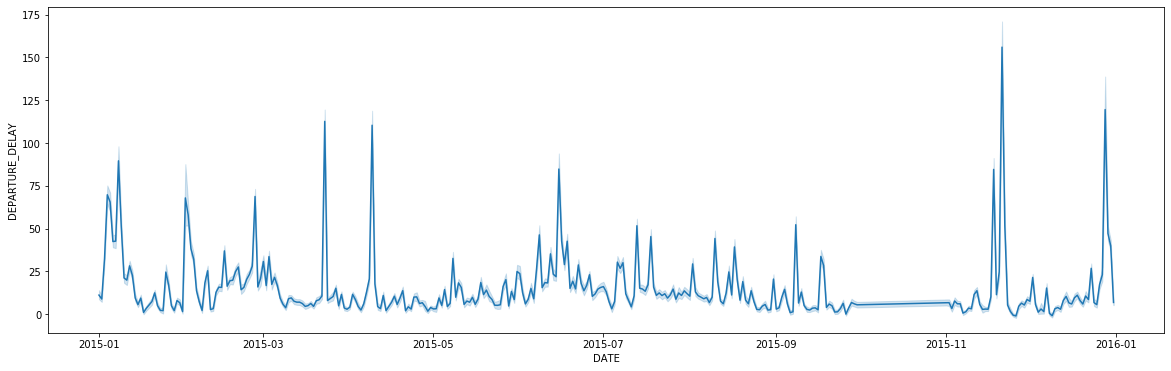

In [8]:
plt.figure(figsize = (20,6))
sns.lineplot(x="DATE", y="DEPARTURE_DELAY", data=df)

It looks like there are some spikes in certain dates. Could it be associated with federal holidays? Lets create a new feature for each flight that contains the nearest delta time between the flight day and one of the federal holidays.

### Creating new temporal features

In [9]:
from datetime import date

holiday= [date(2015,1,1),date(2015,1,19),date(2015,2,16),  date(2015,5,25), date(2015,7, 3), date(2015,9,7), 
        date(2015,10,12), date(2015,11,11),date(2015,11,26),  date(2015,12,25)]

holiday = [pd.to_datetime(x) for x in holiday]


def dis_from_the_nearest_holiday(flight_date):
    """ not a vectorized implementation. Takes a little longer time"""
    
    return min([abs(flight_date - x) for x in holiday])
    

In [10]:
df['time_del'] = df['DATE'].apply(dis_from_the_nearest_holiday)

In [11]:
df['time_del'] = df['time_del'].dt.days

Now lets plot a scatterplot between delta time and the departure delay.

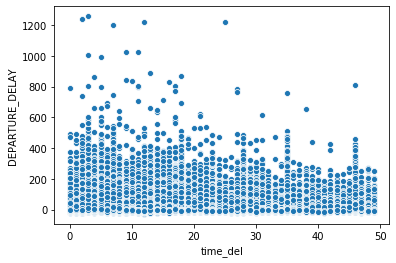

In [12]:
sns.scatterplot(x="time_del", y="DEPARTURE_DELAY", data=df)

It doesn't show the relationship between the two if any. We could also hypothesize that the delay might have been caused by certain weather events such as winter storms in Chicago. To test that hypothesis, we need to pull weather data. But for the sake of this exercise, we will just take a peek by month. 

In [13]:
df.groupby('MONTH')['DEPARTURE_DELAY'].mean()

MONTH
1     19.962051
2     21.832011
3     12.961829
4      9.629107
5     10.969182
6     21.820525
7     15.455429
8     12.705884
9      8.132378
11    12.042743
12    12.321120
Name: DEPARTURE_DELAY, dtype: float64

#### Create a new feature to indicate day of the week

Assuming there were no DAY_OF_WEEK column, we can extract the values from the datetime formatted column.

In [14]:
df['weekdays'] = df['DATE'].dt.dayofweek

In [15]:
df.groupby('weekdays')['DEPARTURE_DELAY'].mean()

weekdays
0    19.448250
1    13.516651
2    13.383585
3    14.576469
4    12.724289
5    11.287391
6    13.618342
Name: DEPARTURE_DELAY, dtype: float64

The day of the week with Monday=0, Sunday=6.

Looks like higher amount of delay occurs on Monday (Monday blues)

In [16]:
df = df.dropna(subset = ["DEPARTURE_DELAY"])

In [17]:
np.corrcoef(df["time_del"], df["DEPARTURE_DELAY"])

array([[ 1.        , -0.02514524],
       [-0.02514524,  1.        ]])

Furthermore, we might want to create a different column which captures the hourly information of the flight departure. The `DEPARTURE_TIME` column is represented as float with digits preceeding decimal indicating the hour time. 

In [18]:
def extract_hour(x):
    
    try:
        return datetime.time(int(np.round(x)))
    except ValueError:
        return np.nan

df['HOUR'] = df["DEPARTURE_TIME"].apply(extract_hour)

In [19]:
df.groupby('HOUR')['DEPARTURE_DELAY'].mean()

HOUR
01:00:00    107.058824
02:00:00    101.368421
03:00:00    144.625000
04:00:00     87.904762
05:00:00    101.500000
06:00:00    183.933333
07:00:00    117.789474
08:00:00    131.133333
09:00:00    139.166667
10:00:00     95.500000
11:00:00    142.875000
12:00:00    156.818182
13:00:00    134.666667
14:00:00    162.687500
15:00:00    143.636364
16:00:00    190.222222
17:00:00    114.066667
18:00:00    155.583333
19:00:00    113.642857
20:00:00    124.600000
21:00:00    153.235294
22:00:00    217.400000
23:00:00    167.636364
Name: DEPARTURE_DELAY, dtype: float64